In [1]:
!wget https://www.dropbox.com/s/ai5z1tospq9hlxo/facial_emotions.zip?dl=0

--2022-08-06 16:08:26--  https://www.dropbox.com/s/ai5z1tospq9hlxo/facial_emotions.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ai5z1tospq9hlxo/facial_emotions.zip [following]
--2022-08-06 16:08:27--  https://www.dropbox.com/s/raw/ai5z1tospq9hlxo/facial_emotions.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9f0d3ac59885355739e5fad3f8.dl.dropboxusercontent.com/cd/0/inline/BqhIuYKtL7hQojSj_dFzq0Mw4PmiFgw9xiiD-wTrfRk001XnWQ2gg1KNRecSyT7O_tb-46q-AKQJG7kQ4Ofmyy9KyqXat5_HbvonvXHAXuJQQm283mlEIpLt9rhdgh3kNnmyGQUoLS1Co1pja6XsAdGQqGCyHCj1pQQUkK3Aj0JvUw/file# [following]
--2022-08-06 16:08:27--  https://uc9f0d3ac59885355739e5fad3f8.dl.dropboxusercontent.com/cd/0/inline/BqhIuYKtL7hQojSj_dFzq0Mw4PmiFgw9xiiD-wTrfR

In [2]:
!unzip /content/facial_emotions.zip?dl=0

Streaming output truncated to the last 5000 lines.
  inflating: images/validation/fear/8797.jpg  
  inflating: images/validation/fear/8818.jpg  
  inflating: images/validation/fear/886.jpg  
  inflating: images/validation/fear/9037.jpg  
  inflating: images/validation/fear/9040.jpg  
  inflating: images/validation/fear/9101.jpg  
  inflating: images/validation/fear/911.jpg  
  inflating: images/validation/fear/9179.jpg  
  inflating: images/validation/fear/9205.jpg  
  inflating: images/validation/fear/9232.jpg  
  inflating: images/validation/fear/9251.jpg  
  inflating: images/validation/fear/9261.jpg  
  inflating: images/validation/fear/9281.jpg  
  inflating: images/validation/fear/9302.jpg  
  inflating: images/validation/fear/9333.jpg  
  inflating: images/validation/fear/9369.jpg  
  inflating: images/validation/fear/9370.jpg  
  inflating: images/validation/fear/9474.jpg  
  inflating: images/validation/fear/949.jpg  
  inflating: images/validation/fear/9602.jpg  
  inflating:

In [12]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Flatten, Dense
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator , img_to_array, load_img
from keras.applications.mobilenet import MobileNet, preprocess_input 
from keras.losses import categorical_crossentropy

In [13]:
# Working with pre trained model 

base_model = MobileNet( input_shape=(224,224,3), include_top= False )

for layer in base_model.layers:
  layer.trainable = False


x = Flatten()(base_model.output)
x = Dense(units=7 , activation='softmax' )(x)

# creating our model.
model = Model(base_model.input, x)

'''hub_layer = hub.KerasLayer('https://tfhub.dev/google/edgetpu/vision/mobilenet-edgetpu-v2-feature-vector/l/2', trainable=False)

num_classes = 7
inputs = tf.keras.Input(shape=(224, 224, 3))
x = hub_layer(inputs)
x = tf.keras.layers.Conv2D(num_classes, 1, name='logits')(x)
x = tf.keras.layers.Activation('softmax', name='probs')(x)
outputs = tf.squeeze(x, axis=[1, 2])

model = tf.keras.Model(inputs, outputs)'''


"hub_layer = hub.KerasLayer('https://tfhub.dev/google/edgetpu/vision/mobilenet-edgetpu-v2-feature-vector/l/2', trainable=False)\n\nnum_classes = 7\ninputs = tf.keras.Input(shape=(224, 224, 3))\nx = hub_layer(inputs)\nx = tf.keras.layers.Conv2D(num_classes, 1, name='logits')(x)\nx = tf.keras.layers.Activation('softmax', name='probs')(x)\noutputs = tf.squeeze(x, axis=[1, 2])\n\nmodel = tf.keras.Model(inputs, outputs)"

In [14]:
model.compile(optimizer='adam', loss= categorical_crossentropy , metrics=['accuracy']  )

In [15]:
train_datagen = ImageDataGenerator(
     zoom_range = 0.2, 
     shear_range = 0.2, 
     horizontal_flip=True, 
     rescale = 1./255
)

train_data = train_datagen.flow_from_directory(directory= "/content/images/train", 
                                               target_size=(224,224), 
                                               batch_size=32,
                                  )


train_data.class_indices

Found 28821 images belonging to 7 classes.


{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [16]:
val_datagen = ImageDataGenerator(rescale = 1./255 )

val_data = val_datagen.flow_from_directory(directory= "/content/images/validation", 
                                           target_size=(224,224), 
                                           batch_size=32,
                                  )

Found 7066 images belonging to 7 classes.


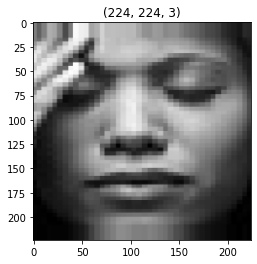

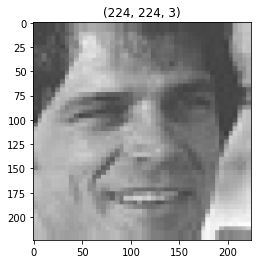

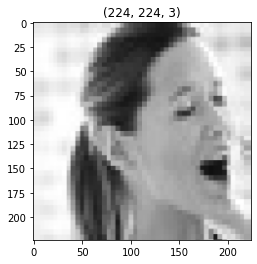

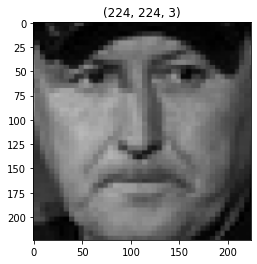

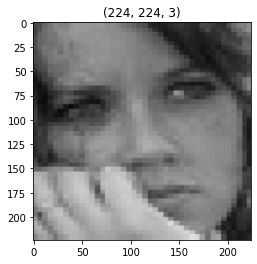

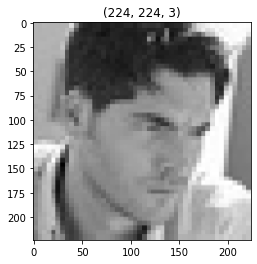

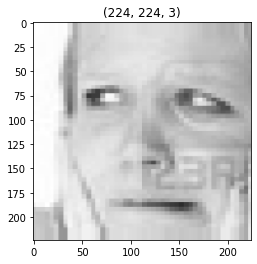

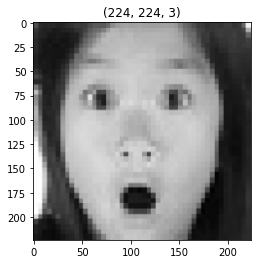

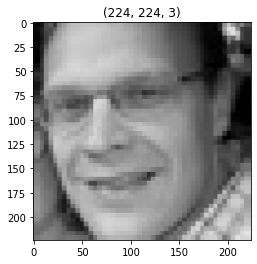

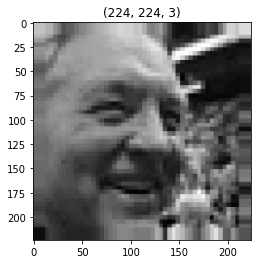

In [17]:
# to visualize the images in the traing data denerator 

t_img , label = train_data.next()

#-----------------------------------------------------------------------------
# function when called will prot the images 
def plotImages(img_arr, label):
  """
  input  :- images array 
  output :- plots the images 
  """
  count = 0
  for im, l in zip(img_arr,label) :
    plt.imshow(im)
    plt.title(im.shape)
    plt.axis = False
    plt.show()
    
    count += 1
    if count == 10:
      break

#-----------------------------------------------------------------------------
# function call to plot the images 
plotImages(t_img, label)

In [18]:
## having early stopping and model check point 

from keras.callbacks import ModelCheckpoint, EarlyStopping

# early stopping
es = EarlyStopping(monitor='val_accuracy', min_delta= 0.01 , patience= 5, verbose= 1, mode='auto')

# model check point
mc = ModelCheckpoint(filepath="facial_emotion_recognition.h5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto')

# puting call back in a list 
call_back = [es,mc]

In [19]:
hist = model.fit(train_data, 
                           steps_per_epoch= 800, 
                           epochs= 30, 
                           validation_data= val_data, 
                           validation_steps= 200, 
                           callbacks=[es,mc])

Epoch 1/30
800/800 [==============================] - ETA: 0s - loss: 7.1512 - accuracy: 0.4350
Epoch 1: val_accuracy improved from -inf to 0.44500, saving model to facial_emotion_recognition.h5
800/800 [==============================] - 268s 333ms/step - loss: 7.1512 - accuracy: 0.4350 - val_loss: 9.4834 - val_accuracy: 0.4450
Epoch 2/30
800/800 [==============================] - ETA: 0s - loss: 7.6123 - accuracy: 0.5034
Epoch 2: val_accuracy improved from 0.44500 to 0.48125, saving model to facial_emotion_recognition.h5
800/800 [==============================] - 263s 329ms/step - loss: 7.6123 - accuracy: 0.5034 - val_loss: 9.0119 - val_accuracy: 0.4812
Epoch 3/30
800/800 [==============================] - ETA: 0s - loss: 7.9096 - accuracy: 0.5374
Epoch 3: val_accuracy did not improve from 0.48125
800/800 [==============================] - 263s 329ms/step - loss: 7.9096 - accuracy: 0.5374 - val_loss: 11.6421 - val_accuracy: 0.4383
Epoch 4/30
800/800 [==============================] - 

KeyboardInterrupt: ignored

In [65]:
# Loading the best fit model 
from keras.models import load_model
model = load_model("/content/facial_emotion_recognition.h5")

In [66]:
h =  hist.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

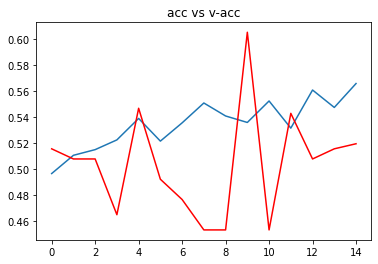

In [67]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'] , c = "red")
plt.title("acc vs v-acc")
plt.show()

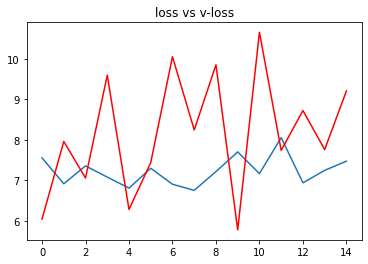

In [68]:
plt.plot(h['loss'])
plt.plot(h['val_loss'] , c = "red")
plt.title("loss vs v-loss")
plt.show()

In [69]:

# just to map o/p values 
op = dict(zip( train_data.class_indices.values(), train_data.class_indices.keys()))

 the image is of happy


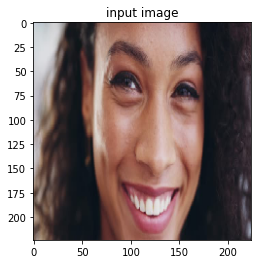

In [72]:
# path for the image to see if it predics correct class

path = "/content/happyhumanface2.jpg"
img = load_img(path, target_size=(224,224) )

i = img_to_array(img)/255
input_arr = np.array([i])
input_arr.shape

pred = np.argmax(model.predict(input_arr))

print(f" the image is of {op[pred]}")

# to display the image  
plt.imshow(input_arr[0])
plt.title("input image")
plt.show()